In [2]:
import tensorflow as tf
import keras
from keras import Model
from keras import layers
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
x_train = np.linspace(0,1,100)
y_train = x_train + np.random.randn(*x_train.shape)*0.1

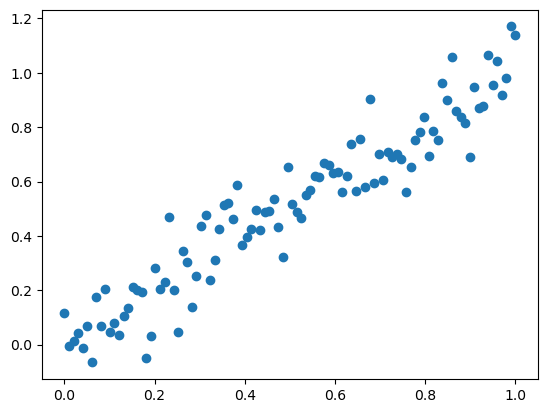

In [19]:
plt.scatter(x_train,y_train)
plt.show()

In [84]:
class DummyModel(Model):
    def __init__(self):
        super().__init__()
        self.flat = tf.keras.layers.Flatten(name="flatten")
        self.dense = layers.Dense(3)
        self.out = layers.Dense(1)
        # self.inppp = layers.Input(shape=(1,))

    def call(self, x):
        # x = self.inppp(x)
        print('in_shape: ', x.shape)
        x = self.flat(x)
        print('flat:',x.shape)
        x = self.dense(x)
        outo = self.out(x)
        print('outo:',outo.shape)
        return outo
        

In [85]:
model = DummyModel()
optimizer = optimizers.Adam(learning_rate = 0.05)
# model.build((1,))
model.compile(optimizer = optimizer, loss='mse', run_eagerly=True)
# model.build((1,))
# model.summary()

In [86]:
hist = model.fit(x_train, y_train, epochs=1, batch_size=16)

in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4157in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (16,)
flat: (16, 1)
outo: (16, 1)
in_shape:  (4,)
flat: (4, 1)
outo: (4, 1)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1990 


In [66]:
hist

(100,)
in_shape:  (32,)
outo: (32, 1)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

in_shape:  (32,)
outo: (32, 1)
in_shape:  (32,)
outo: (32, 1)
in_shape:  (4,)
outo: (4, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
(100, 1)


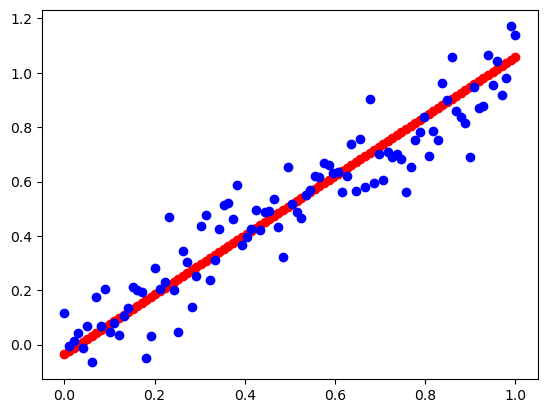

In [81]:
print(x_train.shape)
pred = model.predict(x_train, batch_size=32)
print(pred.shape)
plt.scatter(x_train, pred, color='red')
plt.scatter(x_train, y_train, color='blue')
plt.show()

In [124]:
arr = np.empty(shape=(1,2,3))

In [129]:
len(arr[0])

2

In [53]:
# custom layer definition
class Conv2Plus1D(layers.Layer):
    def __init__(self, kernel_size, filters = 1, strides = (1,1,1), padding = 'valid'):
        """kernel_size is depth width height\n
            If data_format="channels_last"(default): 5D tensor with shape: (batch_size, spatial_dim1, spatial_dim2, spatial_dim3, channels)
        """
        super().__init__()
        wh_stride = (1, strides[1], strides[2])
        t_stride = (strides[0], 1, 1)
        self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]), strides = wh_stride,
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1), strides = t_stride,
                      padding=padding)
        ])

    def call(self, x):
        return self.seq(x)

In [26]:
# pose model
class PoseModel(Model):
    def __init__(self, kernel_size = (17,3)):
        super().__init__()
        self.kernel_size = kernel_size
        self.dense_td = layers.TimeDistributed(layers.Dense(3, activation='relu'))
        self.conv2_x = layers.Conv2D(filters=1, kernel_size = kernel_size)
        self.conv2_y = layers.Conv2D(filters=1, kernel_size = kernel_size)
        self.conv2_z = layers.Conv2D(filters=1, kernel_size = kernel_size)
        self.ln = layers.LayerNormalization()

    def call(self, input, training= False):
        # input shape:  batch time channel features
        # output shape: batch channel conv_result
        temp = self.dense_td(input, training = training)
        # time channel FC_result -> channel time FC_result
        temp = layers.Permute((2, 1, 3))(temp)
        # force add required "channel" input for 2dCNN (not to confuse with xyz channel)
        # shape to: xyz_channel, time, FC_result, 1
        temp = tf.expand_dims(temp, axis=4)
        xyz = tf.split(temp, 3, axis = 1)
        x = self.conv2_x(xyz[0])
        y = self.conv2_y(xyz[1])
        z = self.conv2_z(xyz[2])
        # shape: (batch, 1, FC_res, 1, 1) -> (batch, FC_res) -> (batch, xyz_ch, FC_res)
        x = tf.squeeze(x)
        y = tf.squeeze(y)
        z = tf.squeeze(z)
        temp = tf.stack([x, y, z], axis=1)
        return self.ln(temp, training = training)
        

In [16]:
nmat = np.ones((32,18,3,4))
# batch, frame(time), channel, feature 
tmat = tf.convert_to_tensor(nmat, dtype=tf.float32)
tmat.shape

TensorShape([32, 18, 3, 4])

In [17]:
maty = np.ones((32, 3, 11))
tmaty = tf.convert_to_tensor(maty, dtype=tf.float32)
tmaty.shape

TensorShape([32, 3, 11])

In [27]:
pm = PoseModel(kernel_size=(8,3)) # (time, FC_output)
optimizer = optimizers.Adam(learning_rate = 0.05)
# model.build((1,))
pm.compile(optimizer = optimizer, loss='mse', run_eagerly=False)
# model.build((1,))
# model.summary()

In [41]:
hist = pm.fit(tmat, tmaty, epochs=1, batch_size=16)

2/2 [==============================] - 0s 4ms/step - loss: 2.7484e-04


In [42]:
lol = pm.predict(tmat)
lol

1/1 [==============================] - 0s 20ms/step


array([[[1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0436625, 1.0436625, 1.0436625, ..., 1.0436625, 1.0436625,
         1.0436625]],

       [[1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0436625, 1.0436625, 1.0436625, ..., 1.0436625, 1.0436625,
         1.0436625]],

       [[1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0436625, 1.0436625, 1.0436625, ..., 1.0436625, 1.0436625,
         1.0436625]],

       ...,

       [[1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0437355],
        [1.0437355, 1.0437355, 1.0437355, ..., 1.0437355, 1.0437355,
         1.0

---
**keras layer test**

In [102]:
inputs = layers.Input(shape=(32, 3, 10), batch_size=18)
# frame channel feat
d2 = layers.Dense(3, activation='relu')
outputs = layers.TimeDistributed(d2)(inputs)
outputs.shape

TensorShape([18, 32, 3, 3])

In [103]:
outputs = layers.Permute((2, 1, 3))(outputs)
outputs = tf.expand_dims(outputs, axis=4)
outputs.shape

TensorShape([18, 3, 32, 3, 1])

In [104]:
xyz = tf.split(outputs, 3, axis = 1)

In [105]:
xyz

[<KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>,
 <KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>,
 <KerasTensor: shape=(18, 1, 32, 3, 1) dtype=float32 (created by layer 'tf.split_3')>]

In [147]:
c2 = layers.Conv2D(1, (17,3))
x = c2(xyz[0])
y = c2(xyz[1])
z = c2(xyz[2])
x.shape

TensorShape([18, 1, 16, 1, 1])

In [148]:
x = tf.squeeze(x)
y = tf.squeeze(y)
z = tf.squeeze(z)
x.shape

TensorShape([18, 16])

In [151]:
o = tf.stack([x,y,z], axis=2)
# o = tf.concat([x,y,z], axis = 0)
o.shape

TensorShape([18, 16, 3])

In [43]:
tf.squeeze(outputs)

<KerasTensor: shape=(32, 3, 16, 2) dtype=float32 (created by layer 'tf.compat.v1.squeeze_3')>

- hand model layer test -

In [145]:
inputs = layers.Input(shape=(63, 4, 5, 3), batch_size=32)
# frame, w, h, channel
c21d = Conv2Plus1D(kernel_size=(33,3,3), strides=(2, 1, 1))
outputs = c21d(inputs)
outputs.shape

TensorShape([32, 16, 2, 3, 1])

In [59]:
o2 = layers.Flatten()(outputs)
o2.shape

TensorShape([32, 96])

In [146]:
o2 = outputs
o2 = layers.Reshape((16, o2.shape[2] * o2.shape[3]* o2.shape[4]))(o2)
o2.shape

TensorShape([32, 16, 6])

- combined layer test

In [161]:
l_res = layers.Input(shape=(16, 6), batch_size=32)
r_res = layers.Input(shape=(16, 6), batch_size=32)
p_res = layers.Input(shape=(16, 3), batch_size=32)
fl = layers.Flatten()
lflt =fl(l_res)
rflt = fl(r_res)
pflt = fl(p_res)
ult_flat = tf.concat([lflt, rflt, pflt], axis = 1)
ult_flat.shape

TensorShape([32, 240])

**layer test**

---

**other experiments**

In [138]:
asdf = tf.constant(([0.1, 0.2, 0.3, 0.4],[1, 2, 3, 4], [11,22,33,44]))
# asdf = tf.expand_dims(asdf, axis=0)

asdf.numpy()

array([[ 0.1,  0.2,  0.3,  0.4],
       [ 1. ,  2. ,  3. ,  4. ],
       [11. , 22. , 33. , 44. ]], dtype=float32)

In [140]:
ashpe = asdf.shape
ashpe

TensorShape([3, 4])

In [144]:
asdf = tf.reshape(asdf, (1,12))
ashpe

TensorShape([3, 4])

In [124]:
ababs = tf.split(asdf, 3)
ababs

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.1, 0.2, 0.3, 0.4]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 2., 3., 4.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11., 22., 33., 44.]], dtype=float32)>]

In [125]:
abab = tf.stack([ababs[0],ababs[1],ababs[2]], axis=2)
abab.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1, 4, 3), dtype=float32, numpy=
array([[[ 0.1,  1. , 11. ],
        [ 0.2,  2. , 22. ],
        [ 0.3,  3. , 33. ],
        [ 0.4,  4. , 44. ]]], dtype=float32)>>

In [99]:
tf.transpose(asdf)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.1,  1. , 10. ],
       [ 0.2,  2. , 20. ],
       [ 0.3,  3. , 30. ]], dtype=float32)>

In [92]:
for i,val in enumerate(asdf):
    print(val.numpy())
    print(i)

[1. 1.]
0
[1. 1.]
1
[1. 1.]
2
[1. 1.]
3
